In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
data_path = '../data/'
listing_info_fn = 'listing_info.csv'
test_fn = 'test.csv'
train_fn = 'train.csv'
user_behavior_logs_fn = 'user_behavior_logs.csv'
user_info_fn = 'user_info.csv'
user_repay_logs_fn  = 'user_repay_logs.csv'
user_taglist_fn = 'user_taglist.csv'

### listing_info

In [3]:
listing_info_data = pd.read_csv(data_path+listing_info_fn)

In [4]:
listing_info_data.loc[listing_info_data['user_id'] == 712075].sort_values('auditing_date')

,user_id,listing_id,auditing_date,term,rate,principal
2783443,712075,1380829,2017-11-06,6,8.0,1170
2748581,712075,1519980,2017-11-21,3,7.2,1170
2748706,712075,1519502,2017-11-21,3,7.2,1170
2745463,712075,1532215,2017-11-22,6,7.6,1170
4054662,712075,1563707,2017-11-26,9,7.6,2260
4055979,712075,1563069,2017-11-26,9,7.6,3350
4036246,712075,1582388,2017-11-28,9,7.6,1170
4031252,712075,1587372,2017-11-29,6,7.6,1170
4022399,712075,1596173,2017-11-30,6,7.6,1170
4022284,712075,1596655,2017-11-30,6,7.6,1170


In [5]:
listing_info_data.isnull().sum()

user_id          0
listing_id       0
auditing_date    0
term             0
rate             0
principal        0
dtype: int64

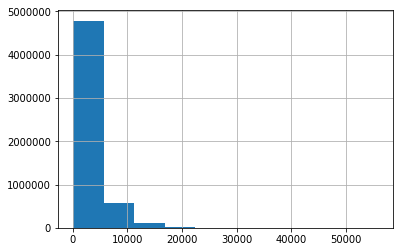

In [6]:
listing_info_data['principal'].hist()

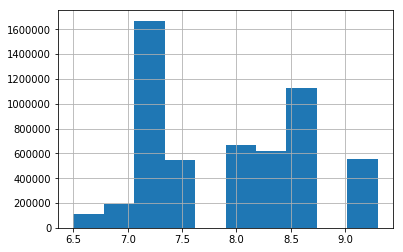

In [7]:
listing_info_data['rate'].hist()

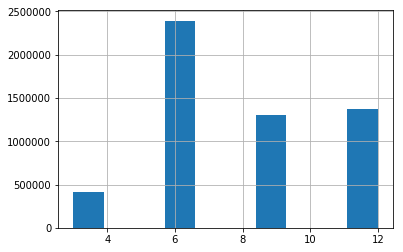

In [8]:
listing_info_data['term'].hist()